In [83]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation
import PIL
import PIL.Image


In [33]:
data_main = pd.read_csv('data_labels_mainData.csv')
data_main.drop(columns=["InstanceID", "patientID"])
data_extra = pd.read_csv('data_labels_extraData.csv')
data_extra.drop(columns=["InstanceID", "patientID"])

,ImageName,isCancerous
0,12681.png,0
1,12682.png,0
2,12683.png,0
3,12684.png,0
4,12685.png,0
...,...,...
10379,20028.png,0
10380,20029.png,0
10381,20030.png,0
10382,20031.png,0


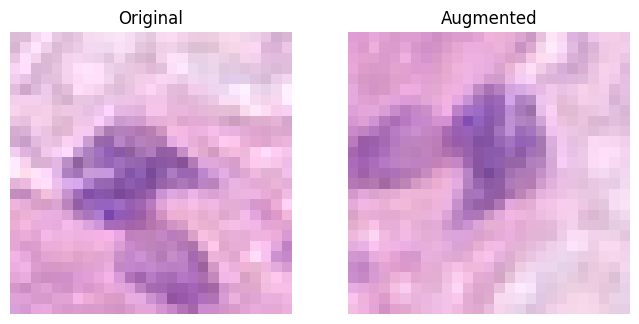

In [107]:
data_cancer = data_main.drop(columns=["cellTypeName", "cellType"])
data_cancer = pd.concat([data_cancer, data_extra])
IMG_SIZE = 27
AugmentData(["1.png"], 10)

In [31]:
cancer_value_counts = data_cancer["isCancerous"].value_count()

print("Proportion of cancerous cells: " + cancer_value_counts.iloc[0,1]/len(cancer_value_counts))

AttributeError: 'Series' object has no attribute 'value_count'

In [99]:
import PIL
import PIL.Image
def AugmentData(imageNames ,maxCount):
    maxCount = len(imageNames)
    dir = "./patch_images/"
    for image in imageNames:
        openedImage = PIL.Image.open(dir + image).convert("RGB")
        
        data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        ])
        image_np = np.array(openedImage)
        image_tensor = tf.convert_to_tensor(image_np, dtype=tf.float32)
        image_tensor = tf.expand_dims(image_tensor, 0)  # Add batch dimension
        
        augmentedImage = data_augmentation(image_tensor)
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.title("Original")
        plt.imshow(openedImage)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Augmented")
        plt.imshow(tf.cast(tf.squeeze(augmentedImage), tf.uint8))
        plt.axis('off')

        plt.show()
        
        break

    return

In [35]:
train_data_cancer, test_data_cancer = train_test_split(data_cancer, test_size=0.2, random_state=42)
train_data_cancer, val_data_cancer = train_test_split(train_data_cancer, test_size=0.25, random_state=42)

In [36]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_DIM),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [37]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560,642 (2.14 MB)

 Trainable params: 560,642 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [39]:
train_data_cancer['isCancerous'] = train_data_cancer['isCancerous'].astype('str')
val_data_cancer['isCancerous'] = val_data_cancer['isCancerous'].astype('str')

In [40]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

print(train_generator)
print(validation_generator)

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [42]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=0, verbose=0)

In [43]:
def plot_learning_curve(title, train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [44]:
plot_learning_curve("SGD Model Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

KeyError: 'loss'

In [45]:
test_data_cancer['isCancerous'] = test_data_cancer['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 4056 validated image filenames belonging to 2 classes.


In [46]:
model.evaluate(test_generator)

C:\Users\harri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  90/4056 ━━━━━━━━━━━━━━━━━━━━ 1:23 21ms/step - categorical_accuracy: 0.7964 - loss: 0.5409

KeyboardInterrupt: 

In [47]:
#Classification
data_type = data_main.drop(columns=["cellTypeName", "isCancerous"])

In [48]:
train_data_type, test_data_type = train_test_split(data_type, test_size=0.2, random_state=42)
train_data_type, val_data_type = train_test_split(train_data_type, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_type.shape[0], val_data_type.shape[0], test_data_type.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [49]:
train_data_type['cellType'] = train_data_type['cellType'].astype('str')
val_data_type['cellType'] = val_data_type['cellType'].astype('str')

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_type,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data_type,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [52]:
model_VGG_1_relu = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4),
])

model_VGG_1_sigmoid = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(4),
])

In [53]:
model_VGG_1_relu.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
model_VGG_1_sigmoid.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


In [54]:
history_VGG_1_relu = model_VGG_1_relu.fit(train_generator, validation_data = validation_generator, epochs=10, verbose=0)
history_VGG_1_sigmoid = model_VGG_1_sigmoid.fit(train_generator, validation_data = validation_generator, epochs=10, verbose=0)

C:\Users\harri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [55]:
test_data_type['cellType'] = test_data_type['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_type,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


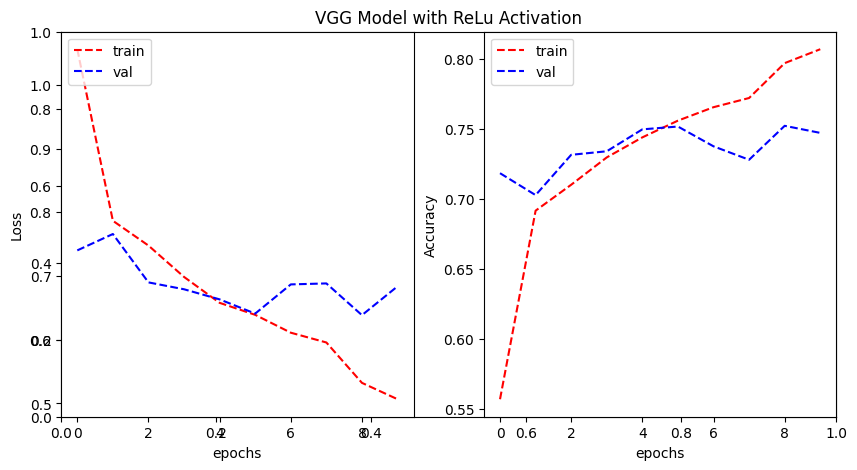

   1/1980 ━━━━━━━━━━━━━━━━━━━━ 3:32 107ms/step - categorical_accuracy: 1.0000 - loss: 0.2189

C:\Users\harri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1980/1980 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - categorical_accuracy: 0.7383 - loss: 0.7116


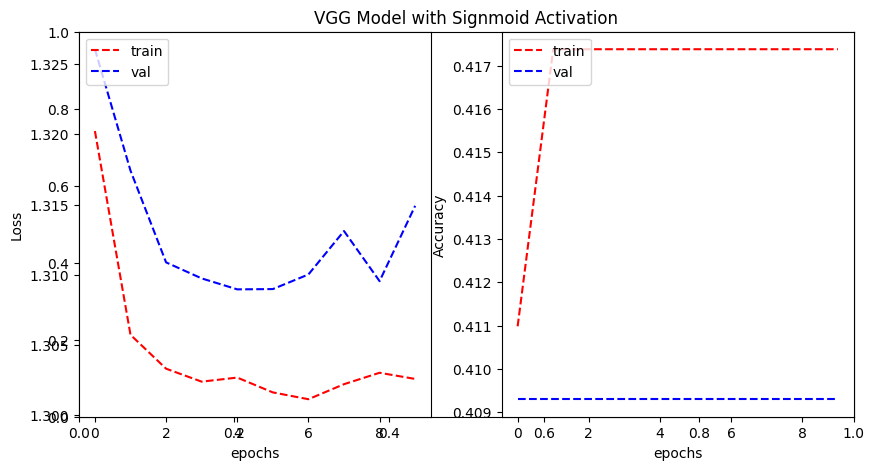

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - categorical_accuracy: 0.3991 - loss: 1.3249


[1.3309401273727417, 0.3994949460029602]

In [56]:
plot_learning_curve("VGG Model with ReLu Activation",history_VGG_1_relu.history['loss'], history_VGG_1_relu.history['val_loss'], 
                    history_VGG_1_relu.history['categorical_accuracy'], history_VGG_1_relu.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_relu.evaluate(test_generator)
plot_learning_curve("VGG Model with Signmoid Activation",history_VGG_1_sigmoid.history['loss'], history_VGG_1_sigmoid.history['val_loss'], 
                    history_VGG_1_sigmoid.history['categorical_accuracy'], history_VGG_1_sigmoid.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_sigmoid.evaluate(test_generator)


This shows a significant amount of overfitting, due to the model learning valuing irrelevant features like noise resulting in worse performance with new data

In [ ]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    # preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # preprocessing.RandomFlip("horizontal"),
    # preprocessing.RandomRotation(0.2),
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(4),
])

model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


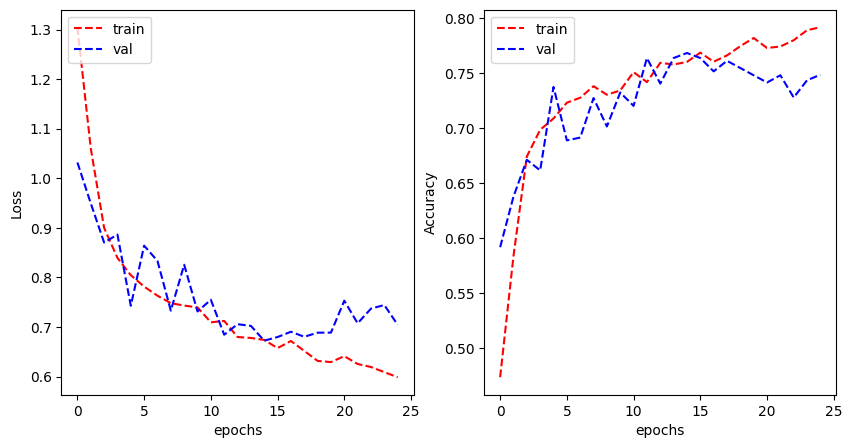

In [ ]:
history_VGG_2 = model_VGG_2.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['categorical_accuracy'], history_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

Significantly better results just with regularization, will try to fit better later